In [1]:
import os
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow.keras as keras

from tqdm.notebook import tqdm
from temnn.analysis.SimulatedAnalysis import Simulated_Data
from os import path

In [2]:
testset = 'Au_fcc_CeO2_MTF4_22112022-test' # use 'Au_fcc_CeO2_MTF4_22112022' for the training data set

dataset = 'Au_fcc_CeO2_MTF4_22112022'

networks = ['MSDnet']
suffices = ['_limit10',
            '_limit25',
            '_limit50',
            '_limit75',
            '_limit100',
            '_limit250',
            '_limit500', 
            '_limit750',
            '_limit1000']

problem = 'Segmentation'

threshold = 0.5

In [3]:
fn = '/home/niflheim2/mhlla/hrid/simulation_data/' + testset ## See README.md - this path will change to ../simulation_data/

In [4]:
image_parameters_file = fn + '/parameters.json'
image_label_files = sorted(glob.glob(fn + '/images_labels/*.npz'))
tem_parameters_files = sorted(glob.glob(fn + '/tem_params/*'))

In [5]:
assert len(image_label_files) == len(tem_parameters_files)
print(len(image_label_files))

500


In [ ]:
# This cell takes time and requires a GPU

for network in tqdm(networks):
    for suffix in tqdm(suffices):
        network_file = f'../trained_networks/{network}_{dataset}{suffix}/model-0'
        mod = keras.models.load_model(network_file, compile=False)
        
        score_list = []
        for i in tqdm(np.arange(len(image_label_files))):
            simulated_data = Simulated_Data(image_label_files[i],
                                            image_parameters_file,
                                            tem_parameters_files[i])
            simulated_data.load()
            image = simulated_data.cp_local_standardise()
            inference = simulated_data.infer(mod)
 
            score_list.append(simulated_data.get_F1_score(threshold, neglect_background=False))
                
        outfile = f'../{network}/{network}_{dataset}{suffix}/{testset}' # Output is stored here
        if not path.exists(outfile):
            os.makedirs(outfile)

        textfile = open(outfile+"/score.txt", "w")
        for element in score_list:
            textfile.write(f'{element}' + "\n")
        textfile.close()

In [6]:
score_trainsize = []
score_trainsize_error = []
for suffix in tqdm(suffices):
    f = f'/home/niflheim2/mhlla/hrid/MSDnet/MSDnet_Au_fcc_CeO2_MTF4_22112022{suffix}/Au_fcc_CeO2_MTF4_22112022/' # read the output stored earlier
    df = pd.read_csv(f+"/score.txt", header=None)
    score_trainsize.append(df.mean(axis=0)[0])
    score_trainsize_error.append(df.std(axis=0)[0]**2)

  0%|          | 0/9 [00:00<?, ?it/s]

In [7]:
score_trainsize_test = []
score_trainsize_error_test = []
for suffix in tqdm(suffices):
    f = f'/home/niflheim2/mhlla/hrid/MSDnet/MSDnet_Au_fcc_CeO2_MTF4_22112022{suffix}/Au_fcc_CeO2_MTF4_22112022-test/'
    #f = f'../MSDnet/MSDnet_Au_fcc_CeO2_MTF4_22112022{suffix}/Au_fcc_CeO2_MTF4_22112022-test/' # read the output stored earlier
    df = pd.read_csv(f+"/score.txt", header=None)
    score_trainsize_test.append(df.mean(axis=0)[0])
    score_trainsize_error_test.append(df.std(axis=0)[0]**2)

  0%|          | 0/9 [00:00<?, ?it/s]

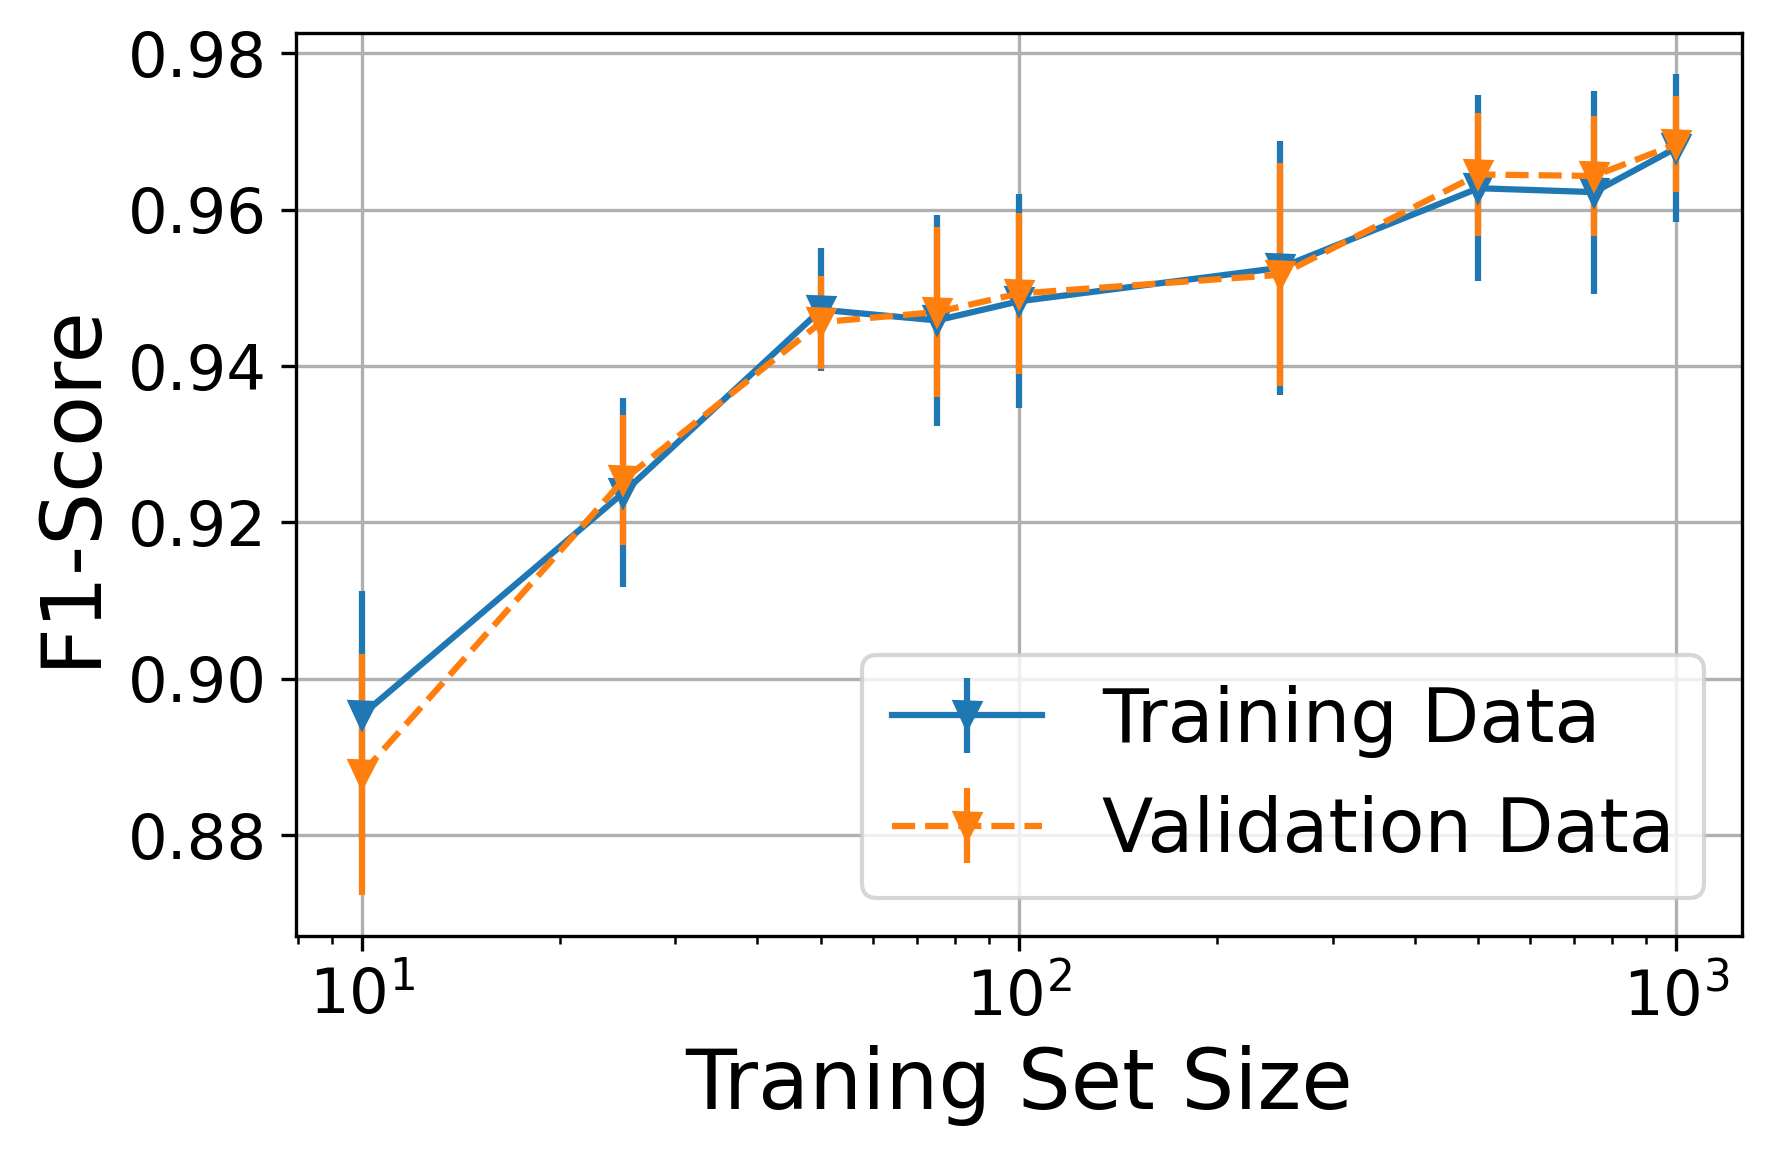

In [8]:
plt.errorbar([10,25,50,75,100,250,500,750,1000],
             score_trainsize,
             score_trainsize_error,
             label='Training Data',
             marker='v')
plt.errorbar([10,25,50,75,100,250,500,750,1000],
             score_trainsize_test,
             score_trainsize_error_test,
             linestyle='--',
             label='Validation Data',
             marker='v')

ax = plt.gca()
ax.set_xscale('log')
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
#ax.ticklabel_format(axis='y', style='sci', scilimits=(.1,.1))
#ax.yaxis.offsetText.set_fontsize(18)
ax.grid()
ax.set_xlabel('Traning Set Size', fontsize=20)
ax.set_ylabel('F1-Score', fontsize=20)

plt.legend(fontsize=18)
plt.tight_layout()
plt.gcf().set_dpi(300)
#plt.savefig('FigureTrainingSize.png')
plt.show()